# BACVP CTD Up Profiles Example
![fig](../figures/bacvp_ctd_up_profiles.jpg "fig")

In [1]:
from datetime import datetime
import gsw
import matplotlib.pyplot as plt
import pandas as pd

from ONCToolbox import ONCToolbox, nan_onc_flags, remove_onc_flags
from ONCToolbox.utils.profilers import identify_profiles

In [2]:
onct = ONCToolbox()

In [3]:
date_from = datetime(2025,6,14,22,0,0,0)
date_to = datetime(2025,6,15,23,59,59,999999)

In [4]:
cl = onct.get_fullres_data(location_code = 'BACVP', 
                            device_category_code = 'DC90', 
                           property_code = 'length',
                           date_from = date_from, 
                           date_to = date_to, 
                           out_as = 'xarray',
                           add_metadata = True)
cable_length = cl.cable_length

In [5]:
ups = identify_profiles(cable_length, profile_direction='up')

In [6]:
ctd = onct.get_fullres_data(location_code = 'BACVP', 
                            device_category_code = 'CTD', 
                           date_from = date_from, 
                           date_to = date_to, 
                           out_as = 'xarray',
                           add_metadata = True)
ctd = nan_onc_flags(ctd)
ctd = remove_onc_flags(ctd)

Data quantity is greater than the row limit and will be downloaded in multiple pages.
Estimated approx. 4 pages in total.
Estimated approx. 33 seconds to complete for the rest of the pages.

   (100000 samples) Downloading page 2...
   (200000 samples) Downloading page 3...
   (300000 samples) Downloading page 4...
   (363278 samples) Completed in 42 seconds.


In [7]:
profiles = []
for up in ups:
    ctd_pro = ctd.sel(time = slice(up['date_from'],up['date_to']))
    
    ctd_pro = ctd_pro.sortby('time')
    ctd_pro = ctd_pro.dropna(dim = 'time', how = 'all')
    ctd_pro = ctd_pro.assign_coords({'profile_id': [pd.to_datetime(ctd_pro.time.min().values).strftime('%Y%m%dT%H%M%SZ')]})
    ctd_pro = ctd_pro.rolling({'time': 5}, center=True, min_periods=1).median(skipna = True) # Apply a rolling median to smooth the data.
    
    ctd_pro['conductivity'] = ctd_pro['conductivity'] * 10
    ctd_pro['conductivity'].attrs['uom'] = 'mS/cm'
    ctd_pro['conductivity'].attrs['unitOfMeasure'] = 'mS/cm'
    
    ctd_pro['practical_salinity'] = gsw.SP_from_C(ctd_pro.conductivity, ctd_pro.temperature, ctd_pro.pressure)
    ctd_pro['absolute_salinity'] = gsw.SA_from_SP(ctd_pro.practical_salinity, ctd_pro.temperature,
                                                            lon =  ctd_pro.attrs['lon'], lat =  ctd_pro.attrs['lat'])
    ctd_pro['conservative_temperature'] = gsw.CT_from_t(ctd_pro.absolute_salinity, ctd_pro.temperature, ctd_pro.pressure)
    ctd_pro['density'] = gsw.density.rho(ctd_pro.absolute_salinity, ctd_pro.conservative_temperature, ctd_pro.pressure)
    ctd_pro['potential_density'] = gsw.sigma0(ctd_pro.absolute_salinity, ctd_pro.conservative_temperature)
    ctd_pro['depth'] = gsw.z_from_p(ctd_pro.pressure, ctd_pro.attrs['lat'])*-1
    
    profiles.append(ctd_pro)

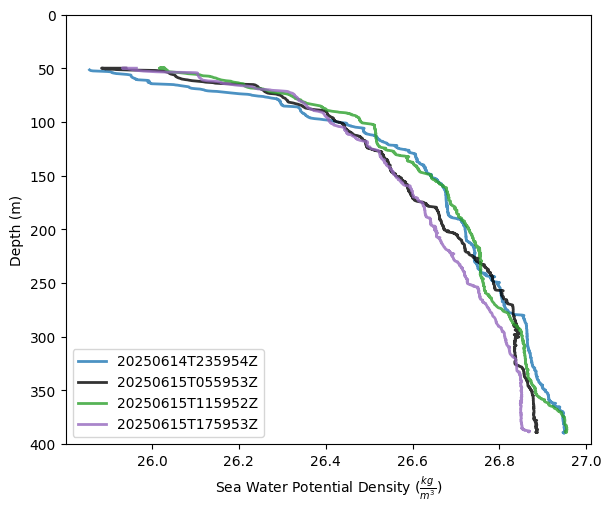

In [8]:
colors = ['tab:blue','black','tab:green','tab:purple']

fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True)

for i in range(len(profiles)):
    pro = profiles[i]
    ax.plot(pro.potential_density, pro.depth, color = colors[i], alpha = 0.8, label = pro.profile_id.values, linewidth = 2)
    
ax.legend(loc = 'lower left')

ax.set_ylim(0,400)

ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel(r'Sea Water Potential Density ($\frac{kg}{m^3}$)')
plt.savefig('../figures/bacvp_ctd_up_profiles.jpg')